可聴域、非可聴域で TDoA 測位


In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from positioning.readwav import readwav
from positioning.sound_db import CeilingTDoADB
from positioning import tools

In [3]:
plt.style.use(["science", "notebook"])

In [4]:
df_true = pd.read_csv("../data/pos-reflect-1ms/measure-points.csv", index_col=0)

In [5]:
db_l = CeilingTDoADB("../data/reference-reflect-1ms", first_freq=1000, last_freq=15000)

In [6]:
test_signal = [readwav(f"../data/pos-reflect-1ms/p{i+28}.wav")[:, 1] for i in range(14)]

In [7]:
est_l = np.array(
    [
        [db_l.positioning(s[i * 120000 : (i + 2) * 120000]) for i in range(100)]
        for s in test_signal
    ]
)

In [8]:
r, theta, phi = tools.rect_to_polar_3d(df_true["x"], df_true["y"], df_true["z"] - 2.2)
df_true["distance"] = r
df_true["azimuth"] = theta
df_true["elevation"] = phi
v_distance, _, _ = tools.rect_to_polar_3d(
    df_true["x"], df_true["y"], df_true["z"] - 2.8
)
df_true["v_distance"] = v_distance
df_true["distance_diff"] = np.abs(df_true["distance"] - df_true["v_distance"])
df_true["sample_diff"] = (df_true["distance_diff"] / 340 * 48000).astype(int)
df_true

,x,y,z,distance,azimuth,elevation,v_distance,distance_diff,sample_diff
p28,-0.25,1.25,1.000,1.750714,-11.309932,43.830861,2.205675,0.454960,64
p29,0.25,1.25,1.000,1.750714,11.309932,43.830861,2.205675,0.454960,64
p30,-0.25,1.75,1.000,2.136586,-8.130102,34.438989,2.522895,0.386309,54
p31,0.25,1.75,1.000,2.136586,8.130102,34.438989,2.522895,0.386309,54
p32,-0.25,1.25,1.250,1.589811,-11.309932,37.234834,2.006863,0.417052,58
p33,0.25,1.25,1.250,1.589811,11.309932,37.234834,2.006863,0.417052,58
p34,-0.25,1.75,1.250,2.006863,-8.130102,28.495639,2.351064,0.344200,48
p35,0.25,1.75,1.250,2.006863,8.130102,28.495639,2.351064,0.344200,48
p36,-0.25,1.25,0.750,1.930673,-11.309932,49.236395,2.414022,0.483348,68
p37,0.25,1.25,0.750,1.930673,11.309932,49.236395,2.414022,0.483348,68


In [9]:
pos_error_l = np.array(
    [
        [
            np.linalg.norm(est_l[i, j, 0:3] - df_true.iloc[i][["x", "y", "z"]].values)
            for j in range(100)
        ]
        for i in range(14)
    ]
)

In [10]:
azimuth_error_l = np.abs(est_l[:, :, 3] - df_true["azimuth"].to_numpy().reshape(-1, 1))
elevation_error_l = np.abs(
    est_l[:, :, 4] - df_true["elevation"].to_numpy().reshape(-1, 1)
)
tdoa_error_l = np.abs(est_l[:, :, 5] - df_true["sample_diff"].to_numpy().reshape(-1, 1))

In [11]:
df_est_l = pd.DataFrame()
for i, d in enumerate(est_l):
    df_est_l = pd.concat(
        [
            df_est_l,
            pd.DataFrame(
                d, columns=["x", "y", "z", "azimuth", "elevation", "tdoa"]
            ).assign(test=i),
        ]
    ).reset_index(drop=True)
df_est_l["position_error"] = pos_error_l.reshape(-1)
df_est_l["azimuth_error"] = azimuth_error_l.reshape(-1)
df_est_l["elevation_error"] = elevation_error_l.reshape(-1)
df_est_l["tdoa_error"] = tdoa_error_l.reshape(-1)
df_est_l.head()

,x,y,z,azimuth,elevation,tdoa,test,position_error,azimuth_error,elevation_error,tdoa_error
0,-0.258075,1.117846,1.092114,-13.0,44.0,65.0,0,0.161291,1.690068,0.169139,1.0
1,-0.267605,1.159126,1.090665,-13.0,43.0,64.0,0,0.129569,1.690068,0.830861,0.0
2,-0.242271,1.139797,1.113376,-12.0,43.0,65.0,0,0.158299,0.690068,0.830861,1.0
3,-0.263385,1.140845,1.069320,-13.0,44.0,64.0,0,0.129997,1.690068,0.169139,0.0
4,-0.262127,1.135396,1.113376,-13.0,43.0,65.0,0,0.161664,1.690068,0.830861,1.0


Text(9.444444444444445, 0.5, 'CDF')

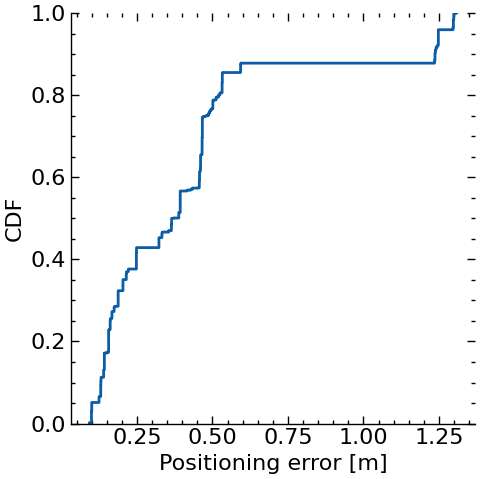

In [12]:
sns.displot(df_est_l, x="position_error", kind="ecdf")
plt.xlabel("Positioning error [m]")
plt.ylabel("CDF")

Text(21.443965277777778, 0.5, 'CDF')

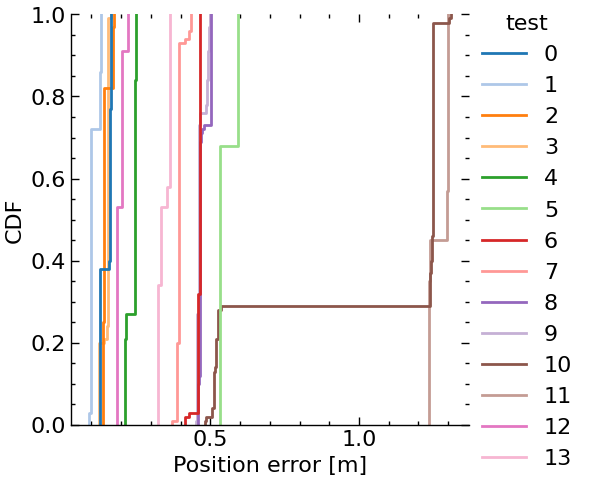

In [38]:
sns.displot(df_est_l, x="position_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("Position error [m]")
plt.ylabel("CDF")

Text(9.444444444444445, 0.5, 'CDF')

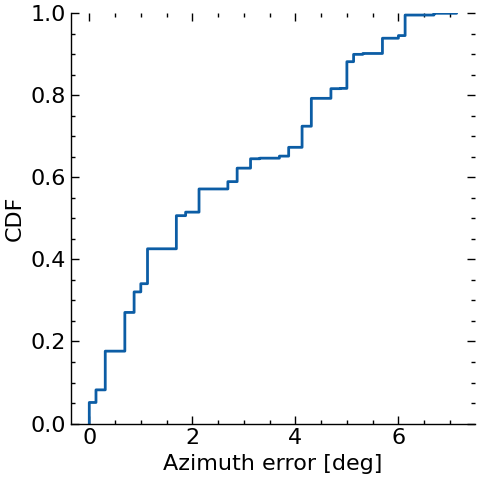

In [16]:
sns.displot(df_est_l, x="azimuth_error", kind="ecdf")
plt.xlabel("Azimuth error [deg]")
plt.ylabel("CDF")

Text(21.443965277777778, 0.5, 'CDF')

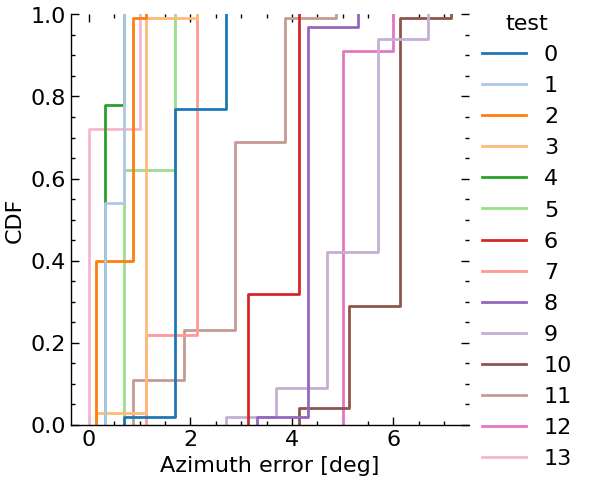

In [39]:
sns.displot(df_est_l, x="azimuth_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("Azimuth error [deg]")
plt.ylabel("CDF")

Text(9.444444444444445, 0.5, 'CDF')

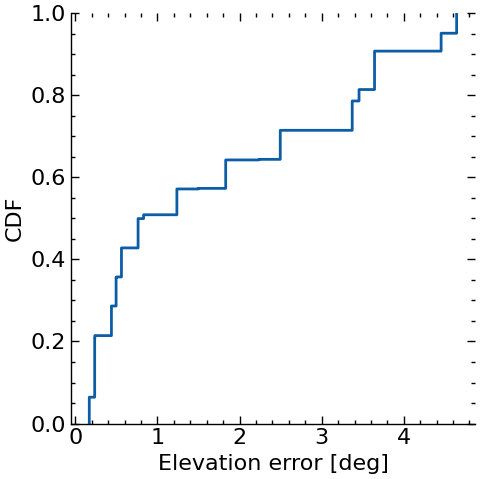

In [18]:
sns.displot(df_est_l, x="elevation_error", kind="ecdf")
plt.xlabel("Elevation error [deg]")
plt.ylabel("CDF")

Text(21.443965277777778, 0.5, 'CDF')

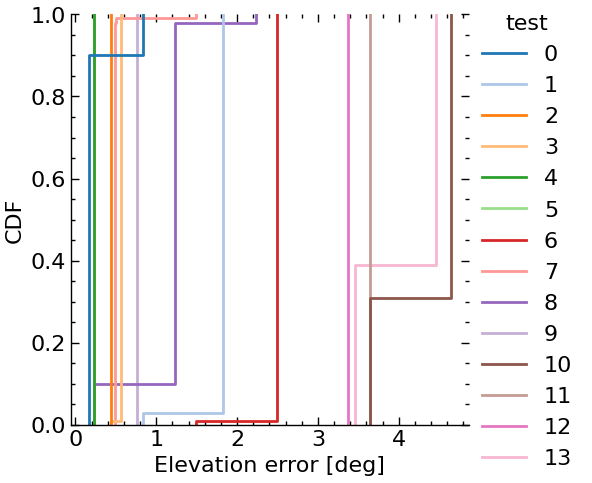

In [40]:
sns.displot(df_est_l, x="elevation_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("Elevation error [deg]")
plt.ylabel("CDF")

Text(9.444444444444445, 0.5, 'CDF')

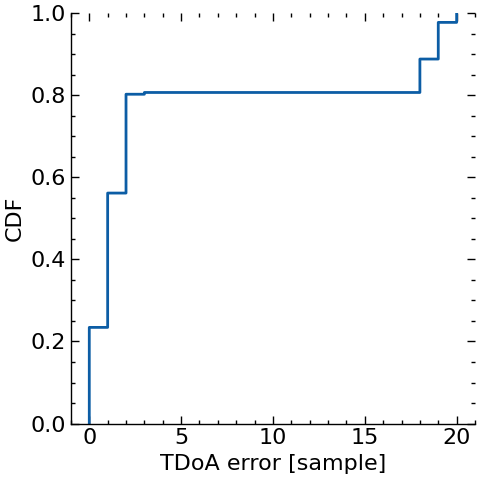

In [19]:
sns.displot(df_est_l, x="tdoa_error", kind="ecdf")
plt.xlabel("TDoA error [sample]")
plt.ylabel("CDF")

Text(21.443965277777778, 0.5, 'CDF')

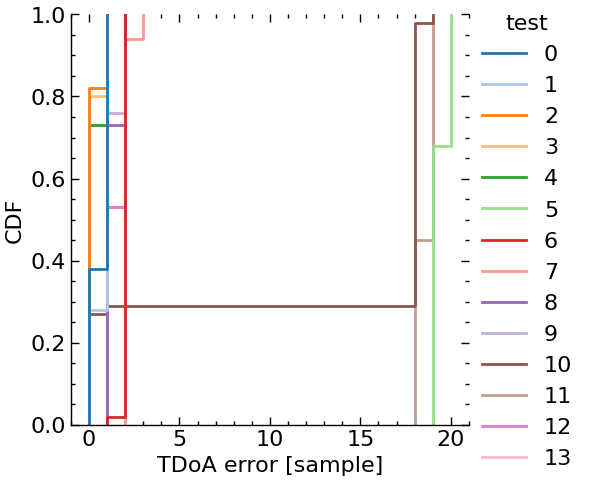

In [41]:
sns.displot(df_est_l, x="tdoa_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("TDoA error [sample]")
plt.ylabel("CDF")

In [35]:
pos_err_l_90p = np.percentile(df_est_l["position_error"], 90)
pos_err_l_50p = np.percentile(df_est_l["position_error"], 50)
azimuth_err_l_90p = np.percentile(df_est_l["azimuth_error"], 90)
azimuth_err_l_50p = np.percentile(df_est_l["azimuth_error"], 50)
elevation_err_l_90p = np.percentile(df_est_l["elevation_error"], 90)
elevation_err_l_50p = np.percentile(df_est_l["elevation_error"], 50)
tdoa_err_l_90p = np.percentile(df_est_l["tdoa_error"], 90)
tdoa_err_l_50p = np.percentile(df_est_l["tdoa_error"], 50)
print(
    f"pos_err_90p: {pos_err_l_90p:.3f}, pos_err_50p: {pos_err_l_50p:.3f},  tdoa_err_90p: {tdoa_err_l_90p:.3f}, tdoa_err_50p: {tdoa_err_l_50p:.3f}"
)
print(
    f"azimuth_err_90p: {azimuth_err_l_90p}, azimuth_err_50p: {azimuth_err_l_50p}, elevation_err_90p: {elevation_err_l_90p}, elevation_err_50p: {elevation_err_l_50p}"
)

pos_err_90p: 1.237, pos_err_50p: 0.368,  tdoa_err_90p: 19.000, tdoa_err_50p: 1.000
azimuth_err_90p: 5.309932474020213, azimuth_err_50p: 1.6900675259797868, elevation_err_90p: 3.6441749571448128, elevation_err_50p: 0.8308606720925908


In [21]:
db_h = CeilingTDoADB("../data/reference-reflect-1ms", first_freq=15000, last_freq=24000)

In [22]:
est_h = np.array(
    [
        [db_h.positioning(s[i * 120000 : (i + 2) * 120000]) for i in range(100)]
        for s in test_signal
    ]
)

In [24]:
pos_error_h = np.array(
    [
        [
            np.linalg.norm(est_h[i, j, 0:3] - df_true.iloc[i][["x", "y", "z"]].values)
            for j in range(100)
        ]
        for i in range(14)
    ]
)

In [25]:
azimuth_error_h = np.abs(est_h[:, :, 3] - df_true["azimuth"].to_numpy().reshape(-1, 1))
elevation_error_h = np.abs(
    est_h[:, :, 4] - df_true["elevation"].to_numpy().reshape(-1, 1)
)
tdoa_error_h = np.abs(est_h[:, :, 5] - df_true["sample_diff"].to_numpy().reshape(-1, 1))

In [26]:
df_est_h = pd.DataFrame()
for i, d in enumerate(est_h):
    df_est_h = pd.concat(
        [
            df_est_h,
            pd.DataFrame(
                d, columns=["x", "y", "z", "azimuth", "elevation", "tdoa"]
            ).assign(test=i),
        ]
    ).reset_index(drop=True)
df_est_h["position_error"] = pos_error_h.reshape(-1)
df_est_h["azimuth_error"] = azimuth_error_h.reshape(-1)
df_est_h["elevation_error"] = elevation_error_h.reshape(-1)
df_est_h["tdoa_error"] = tdoa_error_h.reshape(-1)
df_est_h.head()

,x,y,z,azimuth,elevation,tdoa,test,position_error,azimuth_error,elevation_error,tdoa_error
0,-0.572418,1.032670,0.792888,-29.0,50.0,57.0,0,0.440547,17.690068,6.169139,7.0
1,-0.554308,1.042503,0.792888,-28.0,50.0,57.0,0,0.422557,16.690068,6.169139,7.0
2,-0.564337,1.018090,0.812754,-29.0,50.0,58.0,0,0.433187,17.690068,6.169139,6.0
3,-0.564337,1.018090,0.812754,-29.0,50.0,58.0,0,0.433187,17.690068,6.169139,6.0
4,-0.554308,1.042503,0.792888,-28.0,50.0,57.0,0,0.422557,16.690068,6.169139,7.0


Text(9.444444444444445, 0.5, 'CDF')

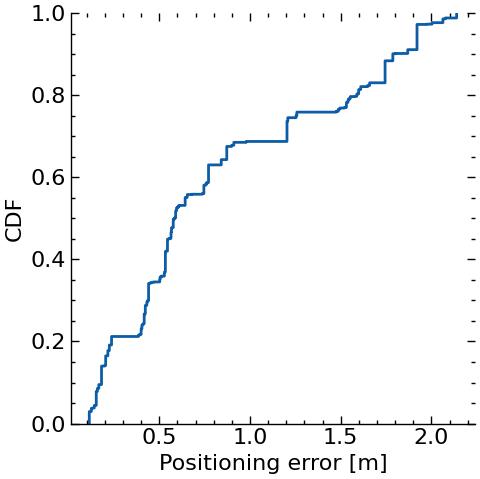

In [27]:
sns.displot(df_est_h, x="position_error", kind="ecdf")
plt.xlabel("Positioning error [m]")
plt.ylabel("CDF")

Text(21.443965277777778, 0.5, 'CDF')

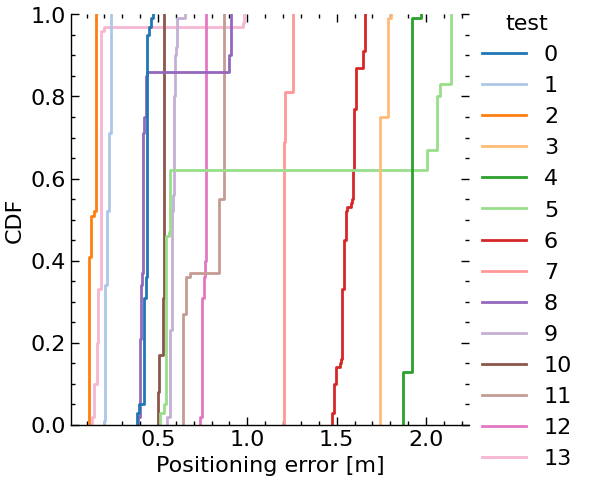

In [42]:
sns.displot(df_est_h, x="position_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("Positioning error [m]")
plt.ylabel("CDF")

/var/folders/y1/_8gjlcgj5vd54qpx7m_q4hlw0000gn/T/ipykernel_80048/1449409760.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(df_est_h, x="azimuth_error", kind="ecdf", palette="tab20")


Text(9.444444444444445, 0.5, 'CDF')

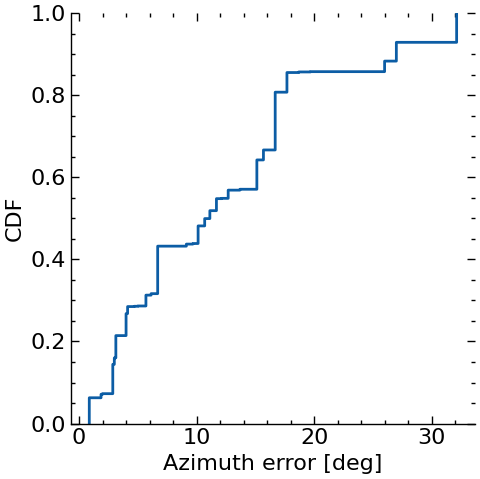

In [43]:
sns.displot(df_est_h, x="azimuth_error", kind="ecdf", palette="tab20")
plt.xlabel("Azimuth error [deg]")
plt.ylabel("CDF")

Text(21.443965277777778, 0.5, 'CDF')

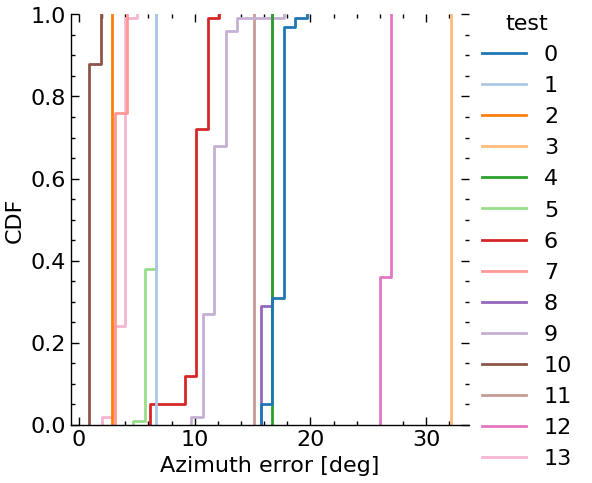

In [44]:
sns.displot(df_est_h, x="azimuth_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("Azimuth error [deg]")
plt.ylabel("CDF")

Text(9.444444444444445, 0.5, 'CDF')

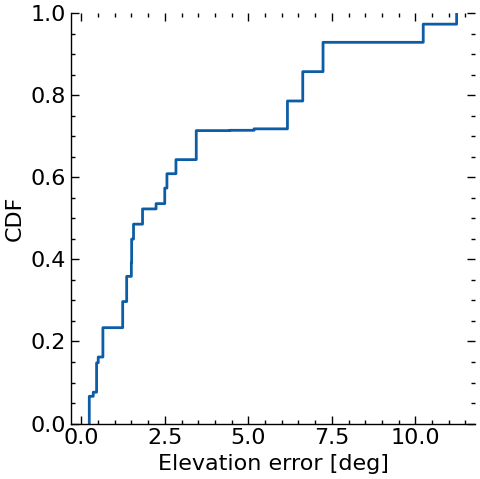

In [31]:
sns.displot(df_est_h, x="elevation_error", kind="ecdf")
plt.xlabel("Elevation error [deg]")
plt.ylabel("CDF")

Text(21.443965277777778, 0.5, 'CDF')

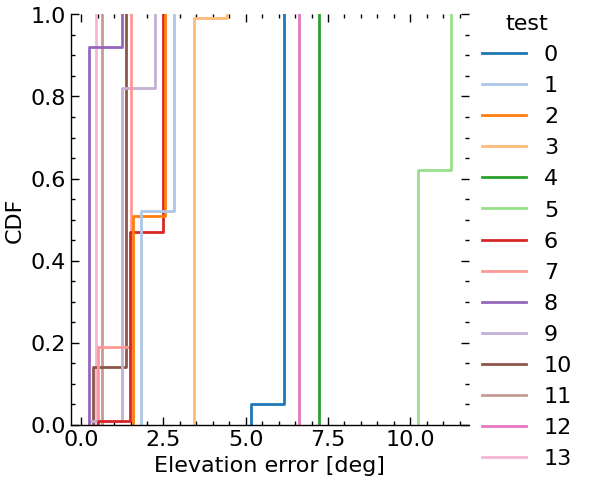

In [45]:
sns.displot(df_est_h, x="elevation_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("Elevation error [deg]")
plt.ylabel("CDF")

Text(9.444444444444445, 0.5, 'CDF')

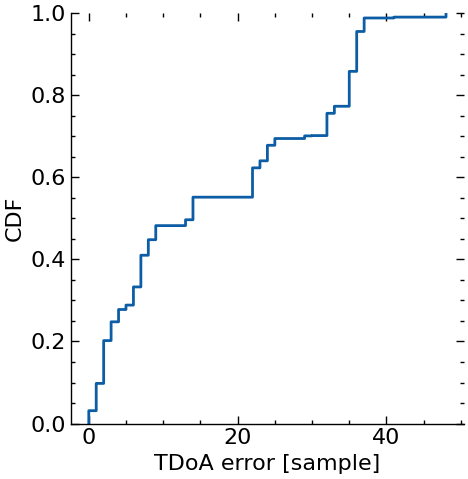

In [33]:
sns.displot(df_est_h, x="tdoa_error", kind="ecdf")
plt.xlabel("TDoA error [sample]")
plt.ylabel("CDF")

Text(21.443965277777778, 0.5, 'CDF')

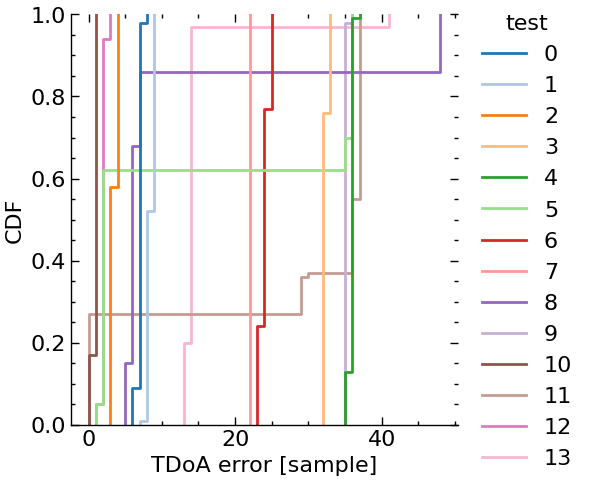

In [46]:
sns.displot(df_est_h, x="tdoa_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("TDoA error [sample]")
plt.ylabel("CDF")

In [36]:
pos_err_h_90p = np.percentile(df_est_h["position_error"], 90)
pos_err_h_50p = np.percentile(df_est_h["position_error"], 50)
azimuth_err_h_90p = np.percentile(df_est_h["azimuth_error"], 90)
azimuth_err_h_50p = np.percentile(df_est_h["azimuth_error"], 50)
elevation_err_h_90p = np.percentile(df_est_h["elevation_error"], 90)
elevation_err_h_50p = np.percentile(df_est_h["elevation_error"], 50)
tdoa_err_h_90p = np.percentile(df_est_h["tdoa_error"], 90)
tdoa_err_h_50p = np.percentile(df_est_h["tdoa_error"], 50)
print(
    f"pos_err_90p: {pos_err_h_90p:.3f}, pos_err_50p: {pos_err_h_50p:.3f},  tdoa_err_90p: {tdoa_err_h_90p:.3f}, tdoa_err_50p: {tdoa_err_h_50p:.3f}"
)
print(
    f"azimuth_err_90p: {azimuth_err_h_90p}, azimuth_err_50p: {azimuth_err_h_50p}, elevation_err_90p: {elevation_err_h_90p}, elevation_err_50p: {elevation_err_h_50p}"
)

pos_err_90p: 1.787, pos_err_50p: 0.582,  tdoa_err_90p: 36.000, tdoa_err_50p: 14.000
azimuth_err_90p: 27.0, azimuth_err_50p: 11.13010235415598, elevation_err_90p: 7.234833981574674, elevation_err_50p: 1.8308606720925908


In [47]:
from positioning.make_wave import reference_transmit_tukey
import scipy.signal as sg

In [54]:
res_signal = test_signal[11][0 * 120000 : (0 + 2) * 120000]
ref_transmit = reference_transmit_tukey(
    first_freq=1000,
    last_freq=15000,
    interval_length=0.1,
    signal_length=0.001,
)  # 参照信号の生成
corr = np.abs(sg.correlate(res_signal, ref_transmit, mode="valid"))  # 相互相関
corr_lags = sg.correlation_lags(len(res_signal), len(ref_transmit), mode="valid")
index_f = corr_lags[corr.argmax()]  # 最大値のインデックス見つける
next_peak = np.argmax(corr[index_f + 20 : index_f + 100]) + index_f + 20
diff = next_peak - index_f

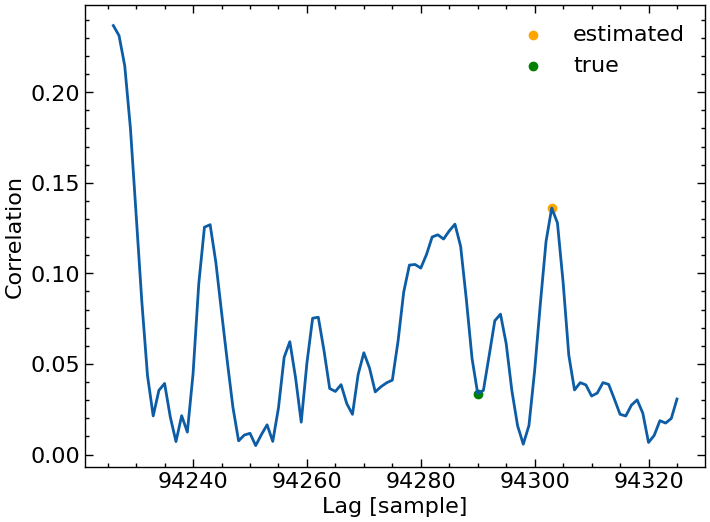

In [55]:
plt.plot(corr_lags[index_f : index_f + 100], corr[index_f : index_f + 100])
plt.scatter(corr_lags[next_peak], corr[next_peak], label="estimated", c="orange")
plt.scatter(corr_lags[index_f + 64], corr[index_f + 64], label="true", c="green")
plt.xlabel("Lag [sample]")
plt.ylabel("Correlation")
plt.legend()